In [11]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import random
rng = np.random.default_rng()
sn.set_style('whitegrid')

In [12]:
#import and create cleaned stimuli strings which can be copied directly into GPT if desired
#find difference score between human ratings (Graves 2013) and GPTv3.5 (March 14)

home_direct = 'C:/Users/Nick/Downloads/meat-kangaroo-main/'

all_words_and_measures = pd.read_csv(home_direct + 'graves_with_vecs.csv', skipinitialspace=True, )
all_words_and_measures = all_words_and_measures.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

all_words_and_measures['Humans Binary'] = np.where(
    all_words_and_measures['Humans Continuous'] >= 2.5, 'Makes Sense', np.where(
    all_words_and_measures['Humans Continuous'] <= 1.5, 'Nonsense', 'Ambiguous'))

#all_words_and_measures['Stim'] = 'the ' + all_words_and_measures['Stim'].str.replace('-', ' ') + '.'
all_words_and_measures['Difference Score'] = abs(all_words_and_measures['Humans Continuous'] - all_words_and_measures['GPT Continuous Temp 0'])

# all_words_and_measures.to_excel('cleaned_words.xlsx')

In [13]:
remove_middle = all_words_and_measures[all_words_and_measures['Humans Binary'].isin(['Makes Sense', 'Nonsense'])]

hits =  732
misses =  59
fas =  730
crs =  247


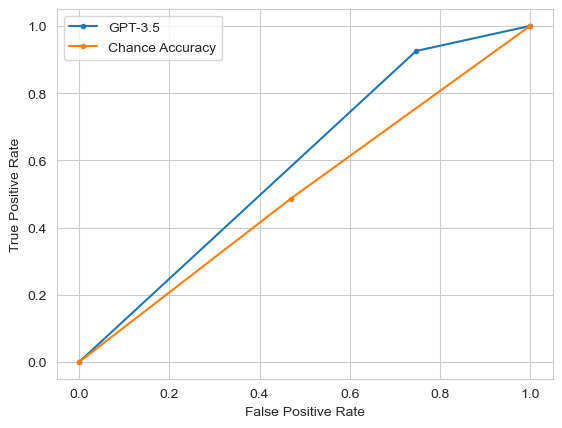

hits =  624
misses =  47
fas =  576
crs =  214


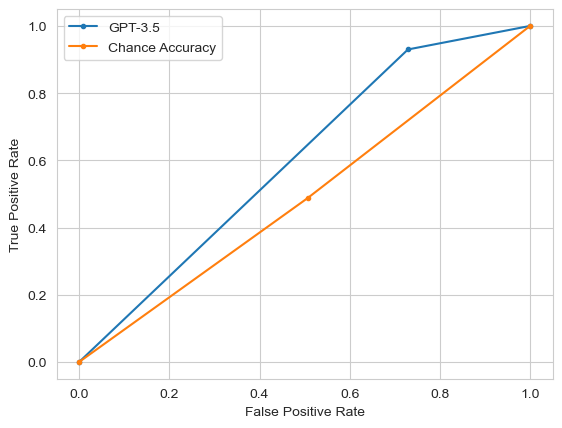

hits =  473
misses =  26
fas =  241
crs =  128


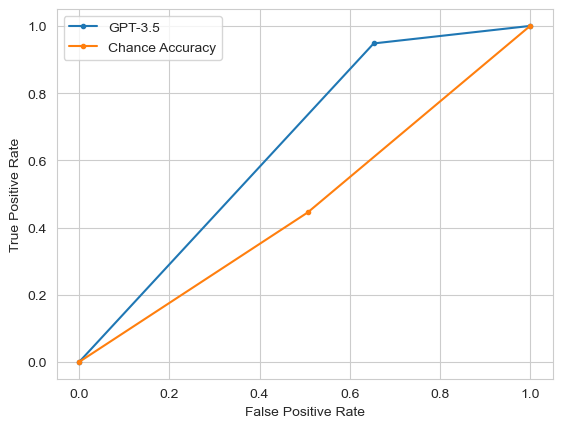

hits =  371
misses =  16
fas =  97
crs =  63


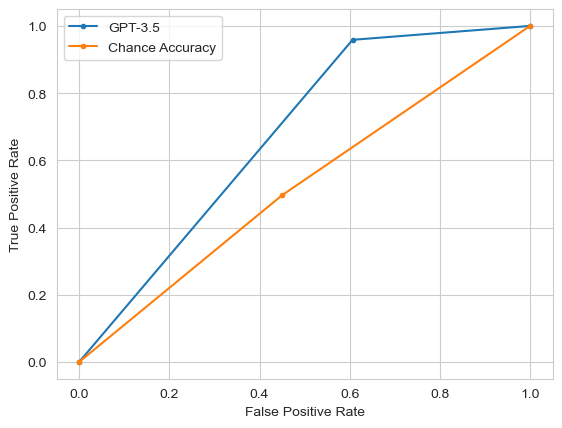

hits =  283
misses =  11
fas =  32
crs =  32


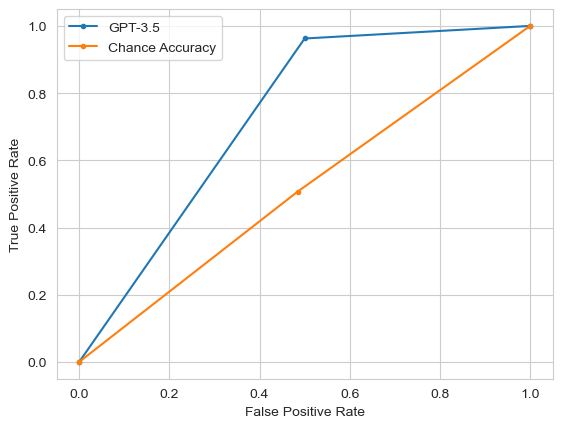

In [15]:
SD = [0,1,1.65,2.32,3.09]

for dev in SD:
    sensible_SD = remove_middle[(remove_middle['Humans Continuous'] >= 2.5) & (remove_middle['Humans Continuous'] - (dev * remove_middle['SD']) >= 1.5)]
    nonsensible_SD = remove_middle[(remove_middle['Humans Continuous'] <= 1.5) & (remove_middle['Humans Continuous'] + (dev * remove_middle['SD']) <= 2.5)]

    remove_by_SD = pd.concat([sensible_SD, nonsensible_SD])

    answer_types = [
    (remove_by_SD['GPT Temp 1'] == 'Makes Sense') & (remove_by_SD['Humans Binary'] == 'Nonsense'),
    (remove_by_SD['GPT Temp 1'] == 'Nonsense') & (remove_by_SD['Humans Binary'] == 'Makes Sense'),
    (remove_by_SD['GPT Temp 1'] == 'Makes Sense') & (remove_by_SD['Humans Binary'] == 'Makes Sense'),
    (remove_by_SD['GPT Temp 1'] == 'Nonsense') & (remove_by_SD['Humans Binary'] == 'Nonsense')
    ]

    answer_names = ['False Alarm', 'Miss', 'Hit', 'Correct Rejection']

    remove_by_SD['Answer Type'] = np.select(answer_types, answer_names)
    
    hits = remove_by_SD['Answer Type'].value_counts()['Hit']
    misses = remove_by_SD['Answer Type'].value_counts()['Miss']
    fas = remove_by_SD['Answer Type'].value_counts()['False Alarm']
    crs = remove_by_SD['Answer Type'].value_counts()['Correct Rejection']

    print('hits = ', hits)
    print('misses = ', misses)
    print('fas = ', fas)
    print('crs = ', crs)
    
    binary_for_ROC = [
    (remove_by_SD['Humans Binary'] == 'Nonsense'),
    (remove_by_SD['Humans Binary'] == 'Makes Sense')
    ]

    binary_for_GPT = [
    (remove_by_SD['GPT Temp 1'] == 'Nonsense'),
    (remove_by_SD['GPT Temp 1'] == 'Makes Sense')
    ]

    labels_for_ROC = [0, 1]

    remove_by_SD['Truth'] = np.select(binary_for_ROC, labels_for_ROC)
    remove_by_SD['Predicted'] = np.select(binary_for_GPT, labels_for_ROC)
    remove_by_SD['Random'] = np.random.randint(0,2,size=len(remove_by_SD))

    truth = remove_by_SD['Truth'].to_numpy()
    predicted = remove_by_SD['Predicted'].to_numpy()
    random = remove_by_SD['Random'].to_numpy()
    
    fpr, tpr, thresholds = roc_curve(truth, predicted, pos_label=1)
    rand_fpr, rand_tpr, thresholds = roc_curve(truth, random, pos_label=1)

    pyplot.plot(fpr, tpr, marker='.', label='GPT-3.5')
    pyplot.plot(rand_fpr, rand_tpr, marker='.', label='Chance Accuracy')
    # plot the roc curve for the model
    pyplot.legend()
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.show()